# Surface Codes Tutorial II
---

Below, we are going to create a class called `SurfaceCodeGraph` which implements a combinatorial object defining a graph which is cellularly embedded in a compact $2$-manifold, i.e. a Riemann surface. This will give us the necessary tools we need to start implementing and studying surface codes on arbitrary surfaces of any genus, and with any qubit connectivity we want. This combinatorial construction is very closely related to quantum gravity, string theory, lattice gauge theories, and number theory (dessins d'enfants), where certain questions in quantum complexity involving partition functions of Ising type models can be translated into questions about L-functions. We will provide references to relevant research papers at the end. 

In building the graph, *bipartite graphs* from NetworkX are used to create *black nodes*, `bipartite=1`, and *white nodes*, `bipartite=0`. For more info on creating bipartite graphs see the [NetworkX documentation](https://networkx.github.io/documentation/stable/reference/algorithms/bipartite.html). 

In [1]:
from collections import Counter
from typing import Tuple, List

from networkx import MultiGraph
from networkx import nx
from networkx.algorithms import bipartite
from sympy.combinatorics import Permutation

import matplotlib.pyplot as plt


# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeGraph(MultiGraph):
    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma  # should include singletons corresponding to fixed points
        self.alpha = alpha  # should include singletons corresponding to fixed points
        f = self.compute_phi()
        self.phi = self.permlist_to_tuple(f)
        self.build_node_info()  # print dictionary for [sigma, alpha, phi]
        self.node_dict = self.sigma_dict, self.alpha_dict, self.phi_dict
        
        self.node_info = ["sigma:", self.sigma_dict, 
                          "alpha:", self.alpha_dict, 
                          "phi:", self.phi_dict]

        self.code_graph = nx.MultiGraph()

        # Create black nodes for each cycle in sigma along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.sigma:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_node(node, bipartite=0)
                self.code_graph.add_edge(cycle, node)

        # Create black nodes for each cycle in phi along with white nodes
        # representing "half edges" around the black nodes
        for cycle in self.phi:
            self.code_graph.add_node(cycle, bipartite=1)
            for node in cycle:
                self.code_graph.add_edge(cycle, node)

        # Create nodes for each cycle in alpha then
        # glue the nodes corresponding to a the pairs
        for pair in self.alpha:
            self.code_graph.add_node(pair)
            self.code_graph = nx.contracted_nodes(self.code_graph, pair[0], pair[1], self_loops=True)
            # Now contract pair with pair[0] to make sure edges (white nodes) are labeled
            # by the pairs in alpha to keep track of the gluing from the previous step
            self.code_graph = nx.contracted_nodes(self.code_graph, pair, pair[0], self_loops=True)
            
        # Define the white and black nodes. White correspond to edges labeled by 
        # cycles in alpha. Black correspond to nodes labeled by cycles in sigma
        # (vertices) and phi (faces)
        self.black_nodes, self.white_nodes = bipartite.sets(self.code_graph)

    def permlist_to_tuple(self, perms):
        """
        convert list of lists to tuple of tuples in order to have two level iterables
        that are hashable for the dictionaries used later
        """
        return tuple(tuple(perm) for perm in perms)

    def compute_phi(self):
        """compute the list of lists full cyclic form of phi (faces of dessin [sigma, alpha, phi])"""
        s = Permutation(self.sigma)
        a = Permutation(self.alpha)
        f = ~(a * s)
        f = f.full_cyclic_form  # prints permutation as a list of lists including all singletons (fixed points)
        return f

    def build_node_info(self):
        count = -1

        self.sigma_dict = dict()
        for count, cycle in enumerate(self.sigma):
            self.sigma_dict[cycle] = count

        self.phi_dict = dict()
        for count, cycle in enumerate(self.phi, start=count + 1):
            self.phi_dict[cycle] = count

        self.alpha_dict = dict()
        for count, pair in enumerate(self.alpha, start=count + 1):
            self.alpha_dict[pair] = count
        return tuple([self.sigma_dict, self.alpha_dict, self.phi_dict])
    
    def boundary_1(self, edge):
        """
        compute boundary of a single edge given by a white node (cycle in alpha)
        """
        boundary1 = [node for node in self.code_graph.neighbors(edge) if node in self.sigma_dict]
        return boundary1
    
    def del_1(self, edges: List[Tuple[int]]):
        """
        boundary of a list of edges, i.e. an arbitrary 1-chain over Z/2Z
        """

        boundary_list = [self.boundary_1(edge) for edge in edges]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def boundary_2(self, face):
        """
        compute boundary of a single face
        """
        boundary = self.code_graph.neighbors(face)
        return boundary

    def del_2(self, faces: List[Tuple[int]]):
        """
        boundary of a list of faces, i.e. an arbitrary 2-chain over Z/2Z
        """

        boundary_list = [self.boundary_2(face) for face in faces]
        a = Counter([y for x in boundary_list for y in x])
        boundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return boundary_list

    def coboundary_1(self, star):
        """
        compute coboundary of a single star
        """
        coboundary = self.code_graph.neighbors(star)
        return coboundary

    def delta_1(self, stars: List[Tuple[int]]):
        """
        coboundary of a list of stars, i.e. an arbitrary 0-cochain over Z/2Z
        """
        coboundary_list = [self.coboundary_1(star) for star in stars]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list
    
    def coboundary_2(self, edge):
        """
        compute coboundary of a single edge given by a white node (cycle in alpha)
        """
        coboundary2 = [node for node in self.code_graph.neighbors(edge) if node in self.phi_dict]
        return coboundary2
    
    def delta_2(self, edges: List[Tuple[int]]):
        """
        coboundary of a list of edges, i.e. an arbitrary 1-cochain over Z/2Z
        given by a list of cycles in alpha
        """
        coboundary_list = [self.coboundary_2(edge) for edge in edges]
        a = Counter([y for x in coboundary_list for y in x])
        coboundary_list = [x[0] for x in a.items() if x[1] % 2 == 1]
        return coboundary_list

    def euler_characteristic(self):
        """
        Compute the Euler characteristic of the surface in which the graph is embedded
        """
        chi = len(self.phi) - len(self.alpha) + len(self.sigma)
        return (chi)

    def genus(self):
        """
        Compute the genus of the surface in which the graph is embedded
        """
        g = int(-(len(self.phi) - len(self.alpha) + len(self.sigma) - 2) / 2)
        return (g)
    
    
    def draw(self, node_type=''):
        """
        Draw graph with vertices, edges, and faces labeled by colored nodes and their integer indices 
        corresponding to the qubit indices for the surface code
        """
        if not node_type in ['cycles', 'dict']:
            raise ValueError('node_type can be "cycles" or "dict"')
    
        pos=nx.spring_layout(self.code_graph)
        # white nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.alpha),
                       node_color='c',
                       node_size=500,
                    alpha=0.3)
        # vertex nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.sigma),
                       node_color='b',
                       node_size=500,
                    alpha=0.6)
         # face nodes
        nx.draw_networkx_nodes(self.code_graph, pos,
                       nodelist=list(self.phi),
                       node_color='r',
                       node_size=500,
                    alpha=0.6)
        # edges
        nx.draw_networkx_edges(self.code_graph, pos, width=1.0, alpha=0.5)

        labels={}

        if node_type == 'cycles':
            '''
            label nodes the cycles of sigma, alpha, and phi
            '''
            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({node})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({node})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({node})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)

        if node_type == 'dict':
            '''
            label nodes with v, e, f and indices given by node_dict corresponding to
            qubit indices of surface code
            '''

            for node in self.alpha_dict:
                # stuff = self.alpha_dict[node]
                labels[node]=f'$e$({self.alpha_dict[node]})'
            for node in self.sigma_dict:
                # something = self.sigma_dict[node]
                labels[node]=f'$v$({self.sigma_dict[node]})'
            for node in self.phi_dict:
                # something2 = self.phi_dict[node]
                labels[node]=f'$f$({self.phi_dict[node]})'
            nx.draw_networkx_labels(self.code_graph, pos, labels, font_size=12)
        
        

# Example 1
---

Here we define two permutations, 

\begin{align}
\sigma &= (0,1,2)(3,4,5)(6,7) \\
\alpha &= (0,3)(1,6)(2,4)(5,7).
\end{align}

The cycles in $\sigma$ will correspond to vertices with *half-edges* attached to them in the cyclic ordering specified by each cycle. In this example, there are three vertices. One is labeled by $(0,1,2)$, the next is labeled by $(3,4,5)$, and the third is labeled by $(6,7)$. The cycles labeling each vertex tell us there are three half-edges connected to the first vertex, three on the second vertex, and two on the third vertex. 

The permutation $\alpha$ gives us a way of *gluing* the half-edges to each other. So the first cycle of $\alpha$, $(0,3)$, tells us to glue the half-edges $0$ and $3$. Similarly, we glue the half-edges $1$ and $6$ since the second cycle of $\alpha$ is $(1,6)$. So, we can take the cycles in $\alpha$ as labels of the edges of the graph we are creating. 

Our class `SurfaceCodeGraph` will create *white* nodes on these edges which are labeled by the cycles of $\alpha$. These wil be important later when we create the class `SurfaceCodeCircuit`. The next thing to note it that once we gave this graph glued together, there is a minimal genus surface into which it naturally embedds. The genus of this surface can be computed very easily once we know what the faces are. To compute the faces we need to compute a third permutations $\phi = (\sigma \alpha)^{-1}$. This is done autimatically by the class, and can be printed off. In our example

\begin{align}
\phi = (0, 4) (1, 3, 7) (2, 6, 5).
\end{align}

In order to perform computations with permutations we use SymPy. The documentation on permutations can be found [here](https://docs.sympy.org/latest/modules/combinatorics/permutations.html). Let's have a look at our example by creating an instance of `SurfaceCodeGraph` corresponding to the permutations

\begin{align}
\sigma &= (0,1,2)(3,4,5)(6,7) \\
\alpha &= (0,3)(1,6)(2,4)(5,7).
\end{align}

In [2]:
sigma = ((0,1,2),(3,4,5),(6,7))
alpha = ((0,3),(1,6),(2,4),(5,7))
SCG = SurfaceCodeGraph(sigma, alpha)
SCG

Now, we can draw the graph with the `draw` method with with option `'cycles'` to label the vertex, edge, and face nodes by the cycles from `sigma`, `alpha`, and `phi` respectively, along with a `v`, `e`, or `f`, depending on whether they correspond to a vertex, edge, or face. 

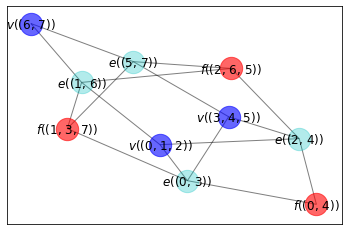

In [3]:
SCG.draw('cycles')

To see which nodes correspond to *faces*, we can print off $\phi$. 

In [4]:
SCG.phi

((0, 4), (1, 3, 7), (2, 6, 5))

Now, we can print off the `node_info`, which is a dictionary built by `SurfaceCodeGraph`. The dictionary enumerates the vertices of the graph correspodning to $\sigma$, $\alpha$, and $\phi$, so that we have a complete enumeration of all vertices of the graph created. 

In [5]:
SCG.node_info

['sigma:',
 {(0, 1, 2): 0, (3, 4, 5): 1, (6, 7): 2},
 'alpha:',
 {(0, 3): 6, (1, 6): 7, (2, 4): 8, (5, 7): 9},
 'phi:',
 {(0, 4): 3, (1, 3, 7): 4, (2, 6, 5): 5}]

This graph has three *black* vertices corresponding to $\sigma$, `0`, `1`, and `2`. There are four *white* vertices corresponding to $\alpha$, `6`, `7`, `8`, and `9`. It also has three more *black* vertices corresponding to $\phi$, `3`, `4`, and `5`. We can print off all of the nodes at once with their original labels given by the cycles of the permutations $\sigma, \alpha$, and $\phi$ as follows. 

In [6]:
SCG.code_graph.nodes

NodeView(((0, 1, 2), (3, 4, 5), (6, 7), (0, 4), (1, 3, 7), (2, 6, 5), (0, 3), (1, 6), (2, 4), (5, 7)))

To see the bipartite sets we can use the following methods, which print of the `white_nodes` and `black_nodes`. 

In [7]:
bipartite.sets(SCG.code_graph)

({(0, 1, 2), (0, 4), (1, 3, 7), (2, 6, 5), (3, 4, 5), (6, 7)},
 {(0, 3), (1, 6), (2, 4), (5, 7)})

In [8]:
SCG.white_nodes

{(0, 3), (1, 6), (2, 4), (5, 7)}

In [9]:
SCG.black_nodes

{(0, 1, 2), (0, 4), (1, 3, 7), (2, 6, 5), (3, 4, 5), (6, 7)}

There is an alternative method for drawing the graph which colors the vertices, edges, and faces with blue, cyan, and red, resepctively. It also prints `v`, `e`, or `f` depending on whether the node corresponds to a vertex, edge, or face, along with the dictionary value corresponding to the integer index that labels the qubits in the surface code (which we discuss a bit later). 

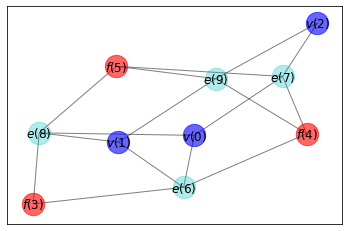

In [10]:
SCG.draw('dict')

We can compute the *Euler characteristic*, which is give by the formula

\begin{align}
\chi &= V-E+F \\
&= |\sigma| - |\alpha| + |\phi|, 
\end{align}

which in our case is 

\begin{align}
3 - 4 + 3 = 2. 
\end{align}

`SurfaceCodeGraph` has a method for computing the Euler characteristic. 

In [11]:
SCG.euler_characteristic()

2

The next natural thing we might want to know is the *genus* of the surface the graph is naturally embedded in. This can be computed using the formula

\begin{align}
\chi &= 2-2g \\
& \implies 2 = 2-2g \\
& \implies 0 = -2g \\
& \implies 0 = g. 
\end{align}

So, we have a genus zero surface, a sphere. `SurfaceCodeGraph` has a method for this as well. 

In [12]:
SCG.genus()

0

Now, something that is important for working with surface codes is computing the *boundary operator* applied to a list of faces. The boundaries are computed over $\mathbb{Z}/2\mathbb{Z}$-homology. This is in general a map that takes faces to edges, and edges to vertices, 

\begin{align}
\partial_2: & F \to E \\
\partial_1: & E \to V. 
\end{align}

So, the way we have constructed our graph, this amounts computing the nodes which are connected to a node corresponding to a face. We can do this for a single face, or for a list of faces. Since we are working with $\mathbb{Z}/2\mathbb{Z}$-homology, which is typical in surface code calculations, we only work with lists of faces. In more general settings, such as $\mathbb{Z}$-homology, we can have a vector with integer entries representing that we have multiple copies of faces, but this is more general than we need here, and the coefficients are just zero or one, so lists of faces will suffice. 

As an example, if we compute the boundary of the face $(1,3,7)$, we get get a list of *white* nodes (always from $\alpha$) which are the boundary. The list will be $[(0, 3), (1, 6), (5, 7)]$. There is a method in `SurfaceCodeGraph` for computing the boundary of arbitrary lists of faces. 

In [13]:
SCG.del_2([(1,3,7)])

[(0, 3), (1, 6), (5, 7)]

Now, let's compute the boundary of $[(0, 4), (1,3,7)]$. 

In [14]:
SCG.del_2([(0, 4), (1,3,7)])

[(2, 4), (1, 6), (5, 7)]

Something important to notice here is that while $e = (0,3)$ is in the boundary of both $(0,4)$ and of $(1,3,7)$, since we are working over $\mathbb{Z}/2\mathbb{Z}$, $2e = 0e = 0$. In other words, two copies is the same as zero copies of an edge since we are working **mod** $2$. Mathematically this can be written as follows, 

\begin{align}
\partial_2((0, 4) + (1,3,7)) &= \partial_2((0, 4)) + \partial_2((1,3,7))\\
&= [(2, 4)+(0, 3)] + [(0, 3) + (1, 6) + (5, 7)] \\
&= 2(0,3) + (2, 4) + (1, 6) + (5, 7)\\
&= (2, 4) + (1, 6) + (5, 7).
\end{align}

Now, we can also compute *coboundaries* of vertices (always given by lists of elements from $\sigma$). Coboundaries of vertices are the edges attached to a vertex. Coboundaries of edges are the faces on either side of the edge. So the coboundary maps are

\begin{align}
\delta_1: & V \to E \\
\delta_2: & E \to F.
\end{align}

As an example, let's use the method of `SurfaceCodeGraph` to compute the coboundary of the vertex $(0,1,2)$. 

In [15]:
SCG.delta_1([(0,1,2)])

[(0, 3), (1, 6), (2, 4)]

This is a list of edges (always given by cycles of $\alpha$, i.e. *white* nodes). Now, Let's compute the *coboundary* of the vertices $[(0,1,2), (3, 4, 5)]$.

In [16]:
SCG.delta_1([(0,1,2), (3,4,5)])

[(1, 6), (5, 7)]

Notice, here again we have the white nodes $(0,3)$ and $(2,4)$ are both in the coboundary of the vertex $(0,1,2)$ and of the vertex $(3,4,5)$. However, since they show up twice, their coefficient is $2$, which is $0$ **mod** $2$. 

Now, let's use the method `boundary_1` which computes the boundary of a single edge (given by a cycle in alpha, which corresponds to a white node in the graph). This should return a list of vertices labeled by cycles of $\sigma$. 

In [17]:
SCG.boundary_1((0,3))

[(0, 1, 2), (3, 4, 5)]

In [18]:
SCG.boundary_1((1,6))

[(0, 1, 2), (6, 7)]

Next, we compute the boundary of a list of edges, i.e. an arbitrary $1$-chain. Here we use the method `del_1` ($\partial_1: E \to V$) and the method should return a list of vertices labeled by cycles in $\sigma$. Again, remember we are working over $\mathbb{Z}/2\mathbb{Z}$ so if there is an overlap in boundaries between two edges, they cancel **mod** $2$. 

In [19]:
SCG.del_1([(0,3), (1,6)])

[(3, 4, 5), (6, 7)]

Notice, the boundary vertex $(0,1,2)$ does not appear since we are working **mod** $2$, i.e. because it is in the boundary of both $(0,3)$ and $(1,6)$. Mathematically we have

\begin{align}
\partial_1((0,3) + (1,6)) &= \partial_1((0,3)) + \partial_1((1,6)) \\
&= [(0,1,2)+(3,4,5)] + [(0,1,2)+(6,7)] \\
&= 2(0,1,2)+(3,4,5)+(6, 7)\\
&= (3, 4, 5) + (6, 7).
\end{align}

Of course, we can use the `coboundary_2` method to compute coboundaries of a single edge too. This will return two faces labeled by cycles in $\phi$ that lie on either side of an edge. 

In [20]:
SCG.coboundary_2((0,3))

[(0, 4), (1, 3, 7)]

In [21]:
SCG.coboundary_2((1,6))

[(1, 3, 7), (2, 6, 5)]

Next, let's combute the coboundary of a list of edges, i.e. an arbitrary $1$-cochain. This is done using the method `delta_2`:

\begin{align}
\delta_2:E \to F.
\end{align}

This will return a list of faces lying on either side of the edges, and as usual it will be over $\mathbb{Z}/2\mathbb{Z}$. 

In [22]:
SCG.delta_2([(0,3), (1,6)])

[(0, 4), (2, 6, 5)]

Mathematically, this is:

\begin{align}
\delta_2((0,3) + (1,6)) &= \delta_2((0,3)) + \delta_2((1,6)) \\
&= [(0, 4) + (1, 3, 7)] + [(1, 3, 7) + (2, 6, 5)] \\
&= (0, 4) + 2(1, 3, 7) + (2, 6, 5)\\
&= (0, 4) + (2, 6, 5),
\end{align}

since we are working over $\mathbb{Z}/2\mathbb{Z}$. 

Now, we are going to create a class `SurfaceCodeCircuit`, which builds a quantum circuit in Qiskit corresponding to a `SurfaceCodeGraph`, which is built from the input data $\sigma, \alpha$. 

In [23]:
from typing import Tuple

from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

# from SurfaceCodes.surface_code_class import SurfaceCodeGraph
# from SurfaceCodes.utilites import permlist_to_tuple


class SurfaceCodeCircuit(QuantumCircuit):

    def __init__(self, sigma: Tuple[Tuple[int]], alpha: Tuple[Tuple[int]]):
        super().__init__()
        self.sigma = sigma
        self.alpha = alpha

        self.scgraph = SurfaceCodeGraph(self.sigma, self.alpha)

        '''
        Compute the permutation corresponding to phi and create a 
        'surface code circuit' based on a (multi)graph 'surface_code_graph'
        given by sigma, alpha, and phi
        Create quantum and classical registers based on the number of nodes in G
        '''
        # f = self.scgraph.compute_phi()
        self.phi = self.scgraph.phi

        self.qr = QuantumRegister(len(self.scgraph.code_graph.nodes))
        self.cr = ClassicalRegister(len(self.scgraph.code_graph.nodes))
        self.circ = QuantumCircuit(self.qr, self.cr)

        self.node_info = self.scgraph.node_dict
        self.sigma_dict, self.alpha_dict, self.phi_dict = self.node_info

        for cycle in self.sigma:
            self.circ.h(self.sigma_dict[cycle])

        for cycle in self.phi:
            self.circ.h(self.phi_dict[cycle])
            

    def x_measurement(self, qubit: int, cbit: int):
        """Measure 'qubit' in the X-basis, and store the result in 'cbit'
        :param qubit, cbit:
        :return None
        """
        # circuit.measure = measure  # fix a bug in qiskit.circuit.measure
        self.circ.h(qubit)
        self.circ.measure(qubit, cbit)
        self.circ.h(qubit)

    def star_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CX gates to surrounding qubits of a star then measures star qubit in X-basis
        :param vertex:
        :return:  self.circ, self.scgraph, self.node_info
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circ.cx(self.sigma_dict[vertex], self.alpha_dict[node])

        self.circ.barrier()
        self.x_measurement(self.sigma_dict[vertex], self.sigma_dict[vertex])
        self.circ.barrier()

        return self.circ, self.scgraph, self.node_info

    def face_syndrome_measure(self, vertex: Tuple[int]):
        """
        Applies CZ gates to surrounding qubits of a face then measures face qubit in X-basis
        :param vertex:
        :return:
        """

        for node in self.scgraph.code_graph.neighbors(vertex):
            self.circ.cz(self.phi_dict[vertex], self.alpha_dict[node])

        self.circ.barrier()
        self.x_measurement(self.phi_dict[vertex], self.phi_dict[vertex])
        self.circ.barrier()

        return self.circ, self.scgraph, self.node_info

    def product_Z(self, faces):
        """
        Pauli product Z operator for arbitrary 2-chain boundary
        """

        boundary_nodes = self.scgraph.del_2(faces)
        for node in boundary_nodes:
            self.circ.z(self.alpha_dict[node])

    def product_X(self, stars):
        """
        Pauli product X operator for arbitrary 0-cochain coboundary
        """
        coboundary_nodes = self.scgraph.delta_1(stars)
        for node in coboundary_nodes:
            self.circ.x(self.alpha_dict[node])
            
    def draw_graph(self, node_type=''):
        if node_type == 'cycles':
            self.scgraph.draw('cycles')
        if node_type == 'dict':
            self.scgraph.draw('dict')

This class will create a Qiskit circuit, with all black nodes of its `SurfaceCodeGraph` (corresponding to $\sigma$ and $\phi$) initialized in the $|+\rangle = H|0\rangle$ state, by applying a Hadamard gate. The *white* nodes, correspnding to the edges of the graph constructed by `SurfaceCodeGraph` (i.e. by cycles of $\alpha$), will be left alone and so will be in the $|0\rangle$ state. 

In [24]:
SCC = SurfaceCodeCircuit(sigma, alpha)

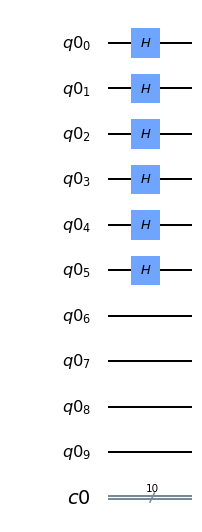

In [25]:
SCC.circ.draw('mpl')

Now, we can draw the corresponding graph, which in this case is the same as the graph we created above for our examples of `SurfaceCodeGraph`. 

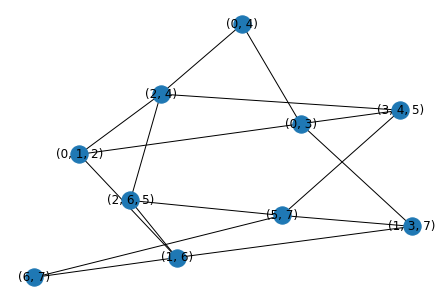

In [26]:
nx.draw(SCC.scgraph.code_graph, with_labels = True)

We can also use the `draw_graph()` method with either `'cycles'` or `'dict'` as the `node_type`. This will draw the same graph as the `SurfaceCodeGraph` method `draw()`. The nodes of the graph will be labeled by a `v`, `e`, or `f` depending on whether the nodes correspond to a ve

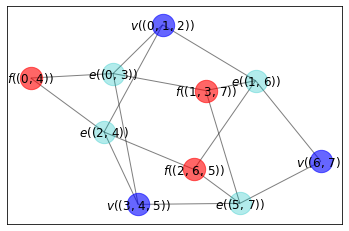

In [27]:
SCC.draw_graph('cycles')

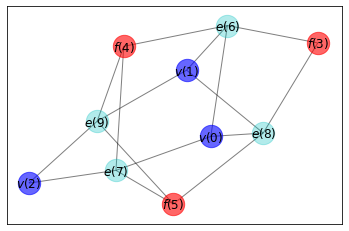

In [28]:
SCC.draw_graph('dict')

We can again print out the `node_info`, which is a dictionary from the node lables to integers. The first row is for $\sigma$, the second row is for $\alpha$, and the third row is for $\phi$. 

In [29]:
SCC.node_info

({(0, 1, 2): 0, (3, 4, 5): 1, (6, 7): 2},
 {(0, 3): 6, (1, 6): 7, (2, 4): 8, (5, 7): 9},
 {(0, 4): 3, (1, 3, 7): 4, (2, 6, 5): 5})

We can print $\sigma, \alpha$, and $\phi$. 

In [30]:
SCC.sigma

((0, 1, 2), (3, 4, 5), (6, 7))

In [31]:
SCC.alpha

((0, 3), (1, 6), (2, 4), (5, 7))

In [32]:
SCC.phi

((0, 4), (1, 3, 7), (2, 6, 5))

We can also print of all of the nodes which are labeles by the cycles of $\sigma, \alpha$, and $\phi$. 

In [33]:
SCC.scgraph.code_graph.nodes

NodeView(((0, 1, 2), (3, 4, 5), (6, 7), (0, 4), (1, 3, 7), (2, 6, 5), (0, 3), (1, 6), (2, 4), (5, 7)))

Now, there is a `star_syndrome_measure` method in SurfaceCodeCircuit which implements the generalization of the following *syndrome measurement* found on page 108 of [Quantum Computation with Topological Codes: from qubit to topological fault-tolerance](https://arxiv.org/pdf/1504.01444.pdf):

![syndrome_measurements.png](syndrome_measurements.png)
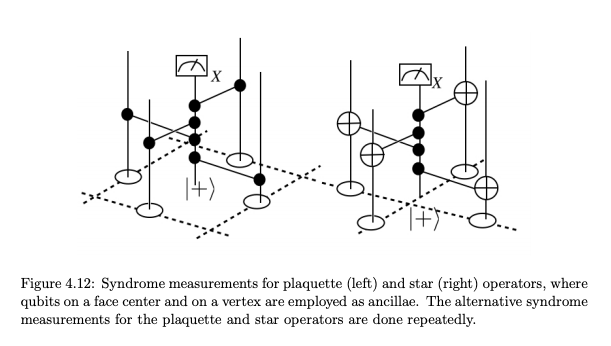

The picture above (on the right) is for *star* syndrome measurements of the *toric code*, however our implementation will work for *arbitrary* surface codes given by *arbitrary* graphs embedded in surfaces. This will apply Controlled-$Z$ gates from a qubit corresponding to a vertex (given by a cycle in $\sigma$) to the target qubits given by the coboundary of that vertex, which are edges connected to it labeled by *white* nodes (corresponding to cycles in $\alpha$). The picture above (on the left) also has *plaquette* measurements. Again, our implementation will work for arbitrary surface codes (for arbitrary graphs embedded in surfaces). The *plaquette syndrome measurement* will apply Controlled-$NOT$ gates with source qubit given by a qubit corresponding to a face, and target qubits given by the boundary of that face. The boundary will correspond to *white* nodes (given by cycles in $\alpha$). Let's apply the star syndrome measurement for the vertex $(0,1,2)$. 

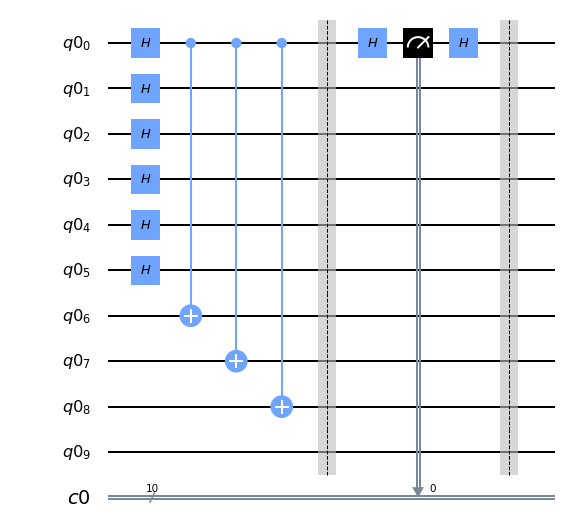

In [34]:
SCC.star_syndrome_measure(((0,1,2)))
SCC.circ.draw('mpl')

Now, let's apply the plaquette syndrome measurement corresponding to the face $(2,6,5)$. 

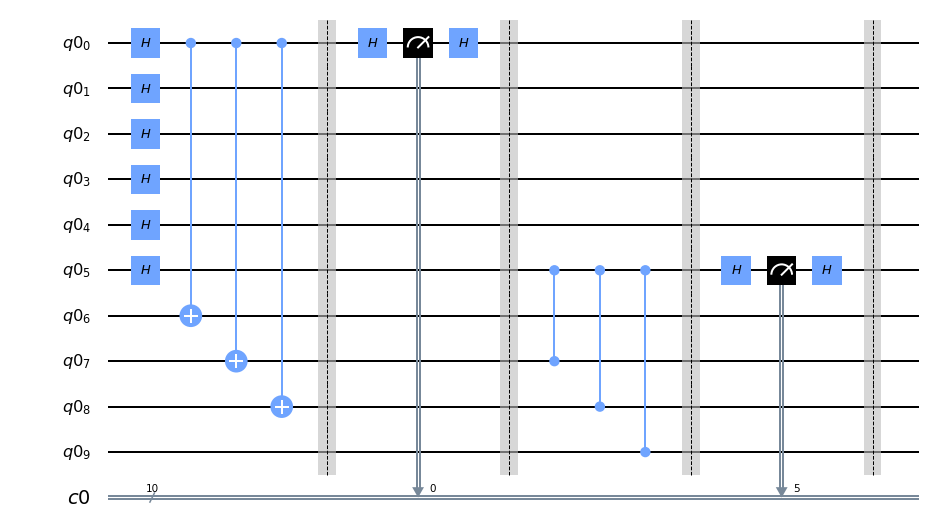

In [35]:
SCC.face_syndrome_measure(((2, 6, 5)))
SCC.circ.draw('mpl')

Again, it is important to note that if our list of faces or stars is given as input for the above two functions has faces with edges in common, an even number of occurences of the same edge means that edge doesn't show up in the output. On the other hand if there are an odd number of occurence of an edge, that edge does show up in the output. This reflects the $\mathbb{Z}/2\mathbb{Z}$-chain complex structure. This can all be phrased in terms of linear algebra and treating $V$, $E$, and $F$ as vector spaces over $\mathbb{Z}/2\mathbb{Z}$. For more background on the math involved see Chapter 3 of [Quantum Computation with Topological Codes: from qubit to topological fault-tolerance](https://arxiv.org/pdf/1504.01444.pdf).

At this point we should mention that a list of faces will form a $2$-chain, and a list of stars (vertices in $\sigma$) forms a $0$-cochain. From this, along with the boundary and coboundary operators we just defined, we can define the Pauli product operators. The first kind of Pauli product operators we define are 

\begin{align}
W(c_1) = \bigotimes_{k}W(e_k)^{n(k)},
\end{align}

where $n(k) \in \{0,1\}$, and $c_1$ is a "$1$-chain" given by a list of edges (each edge corresponding to a cycle in $\alpha$). Each $W_k \in \{X_k, Y_k, Z_k\}$ is a Pauli operator that operates on the $k^{th}$ qubit, where $k$ is the index of the qubit corresponding to an edge. We can get this index using `node_info`, in particular `alpha_dict`, the middle dictionary, which gives us the indices of qubits corresponding to each edge (white node). 

Now, if we compute the boundary $\partial_2(c_2)$ of a $2$-chain (given by a list of faces), we will get a $1$-chain. This $1$-chain will be a list of edges that form the boundary of the faces. From this, we can compute the "**plaquette operators**", i.e. **face operators**, 

\begin{align}
Z(\partial_2f_k) = \bigotimes_{e_j \in \partial_2f_k} Z(e_j)
\end{align}

where $\partial_2f_k$ is the edge list forming the boundary of the face $f_k \in F$. We can also computer the "**star operators**", 

\begin{align}
X(\delta_1 v_m) = \bigotimes_{e_j \in \delta_1v_m} X(e_j), 
\end{align}

where $\delta_1 v_m$ is the edge list forming the *coboundary* of the vertex $v_m$ (which corresponds to some cycle permutation in $\sigma$). These form the **stabilizer generators** for the surface code. For a refresher on stabilizer generators we refer to the notebooks on [error correction](https://github.com/The-Singularity-Research/error-correction) and on [graph states](https://github.com/The-Singularity-Research/graph-state-quantum-cryptography/blob/master/certifying_graph_states.ipynb). Now, let's define a Pauli product $Z$ operator $Z(\partial_2 c_2)$ for the boundary of an arbitray $2$-chain $c_2$, as well as a Pauli product $X$ operator $X(\delta_1 c_0)$ for the coboundary of an arbitrary $0$-cochain $c_0$. The following image can be found on page 76 of [Quantum Computation with Topological Codes: from qubit to topological fault-tolerance](https://arxiv.org/pdf/1504.01444.pdf), and the table below can be found on page 68. 

![torus_code.png](torus_code.png)
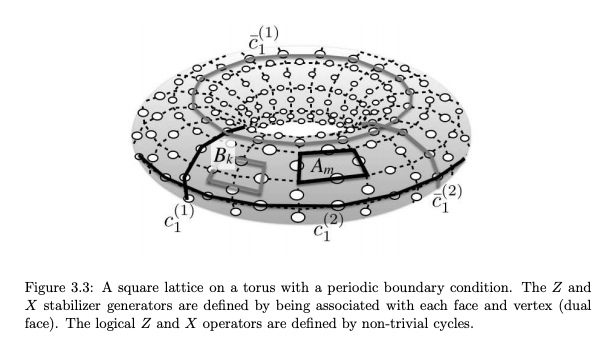

![table.png](table.png)
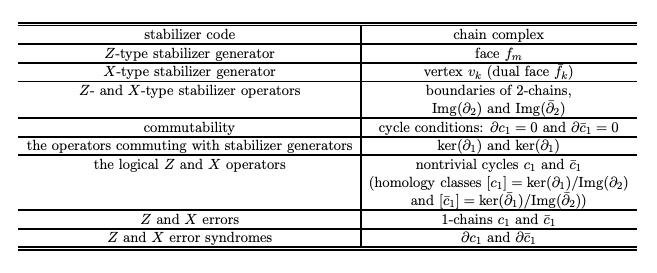

We can apply the *Pauli product*-$Z$ operator corresponding to arbitrary $2$-chain boundaries. Let's do this for the list of two faces $[(0, 4), (2, 6, 5)]$.

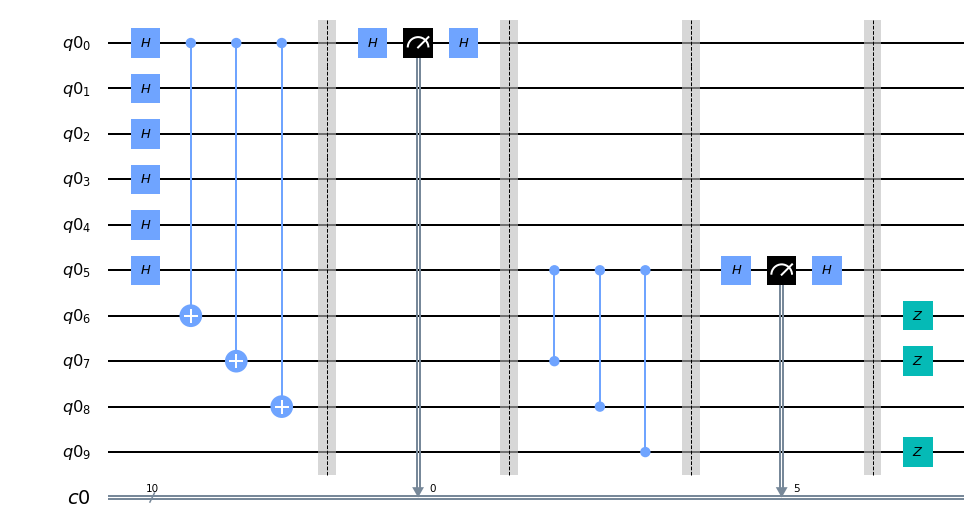

In [36]:
SCC.product_Z([(0, 4), (2, 6, 5)])
SCC.circ.draw('mpl')

We can also apply the *Pauli product*-$X$ operator corresponding to arbitrary $0$-cochain coboundaries. Let's do this for the list of two vertices $[(3, 4, 5), (6, 7)]$.

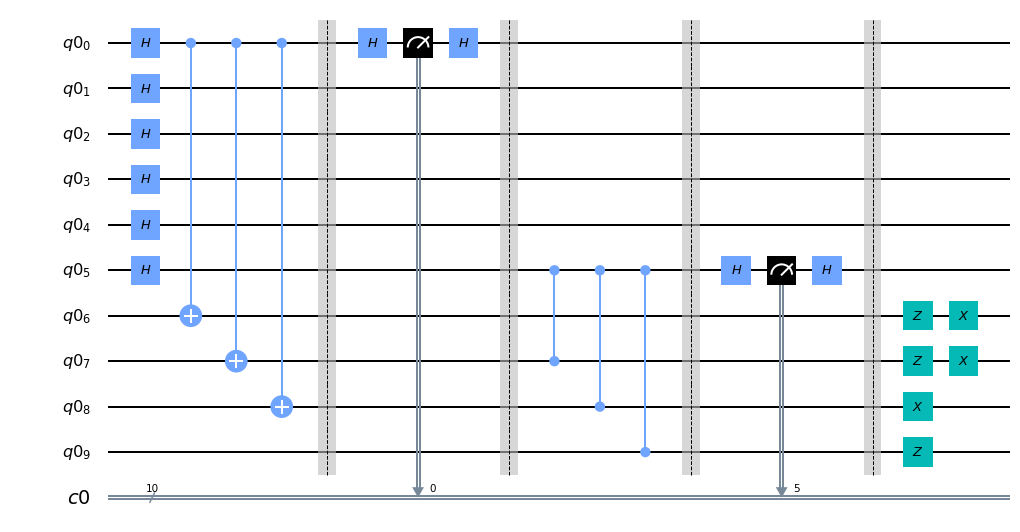

In [37]:
SCC.product_X([(3, 4, 5), (6, 7)])
SCC.circ.draw('mpl')

The two methods `product_Z` and `product_X` use the methods `del_2` and `delta_1` of `SurfaceCodeGraph`, respectively, in order to compute boundaries of faces and coboundaries of vertices to apply the Pauli-$Z$ and Pauli-$X$ gates to. 

## References

### Quantum Computing and Surface Codes

- [Quantum Computation with Topological Codes: from qubit to topological fault-tolerance](https://arxiv.org/pdf/1504.01444.pdf)

- [A graph-based formalism for surface codes and twists](https://www.youtube.com/watch?v=Ca85qdptceQ)

- [Constructions and Noise Threshold of Hyperbolic Surface Codes](https://arxiv.org/pdf/1506.04029.pdf)

- [Homological Quantum Codes Beyond the Toric Code](https://arxiv.org/pdf/1802.01520.pdf)

- [Hyperbolic Lattices in Circuit Quantum Electrodynamics](https://arxiv.org/pdf/1802.09549.pdf)

- [Quantum Simulation of Hyperbolic Space with Circuit Quantum Electrodynamics: From Graphs to Geometry](https://arxiv.org/pdf/1910.12318.pdf)

- [Quantum Error Correction for Quantum Memories](https://arxiv.org/pdf/1302.3428.pdf)

- [Ribbon Graphs on nLab](https://ncatlab.org/nlab/show/ribbon+graph)

### Quantum Gravity and String Theory

- [Maxim Kontsevich, Intersection Theory on the Moduli Space of Curves and the Matrix Airy Function](http://pagesperso.ihes.fr/~maxim/TEXTS/Intersection%20theory%20and%20Airy%20function.pdf)

- [Ed Witten, On the Kontsevich Model and other Models of Two-Dimensional Gravity](https://lib-extopc.kek.jp/preprints/PDF/1992/9203/9203552.pdf)

- [Lando & Zvonkin, Graphs on Surfaces and Their Applications](https://link.springer.com/book/10.1007/978-3-540-38361-1)

### The Langlands Program and the Generalized Riemann Hypothesis

- [SURFACE ALGEBRAS I: DESSINS D’ENFANTS, SURFACE ALGEBRAS, AND DESSIN
ORDERS](https://arxiv.org/pdf/1810.06750.pdf)

- [SURFACE ALGEBRAS AND SURFACE ORDERS II: AFFINE BUNDLES ON CURVES](https://arxiv.org/pdf/1812.00621.pdf)

### Hardware Related Papers

- [Hyperbolic Lattices in Circuit Quantum Electrodynamics](https://arxiv.org/pdf/1802.09549.pdf)

- [Hyperbolic Lattices in Circuit Quantum Electrodynamics](https://arxiv.org/pdf/1802.09549.pdf)